# HW6: Imitation Learning

> - Full Name: **Ariana koocheki Dariuni**
> - Student ID: **400103624**
<!--

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DeepRLCourse/Homework-5-Questions/blob/main/RL_HW11_Dyna.ipynb)
[![Open In kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/DeepRLCourse/Homework-11-Questions/main/RL_HW5_Dyna.ipynb) -->

## Overview
This assignment investigates the strengths and limitations of both reinforcement learning (PPO, A2C) and imitation learning (DAgger, GAIL) by applying them to control tasks. Students train and evaluate agents using expert demonstrations and environment feedback, gaining hands-on experience in designing and comparing learning algorithms across paradigms.


### **Exercise 1: Training PPO, A2C, and DAgger on CartPole-v1** (60 Points)

This exercise focuses on comparing reinforcement learning (PPO, A2C) and imitation learning (DAgger) techniques on the CartPole-v1 environment. An expert policy is first trained using PPO, then used to guide a DAgger agent. Separately, an A2C agent is trained directly via interaction with the environment. Performance metrics are collected to assess how each approach learns and generalizes.

---

### **Exercise 2: Training a GAIL Model Using an Expert Policy** (100 Points)

In this task, a GAIL (Generative Adversarial Imitation Learning) agent is trained to imitate a pre-trained expert policy in several environments (e.g., CartPole-v1, Pendulum-v0, BipedalWalker-v3). The training process involves configuring the environment, initializing models, and iteratively training the agent to match the expert’s behavior using adversarial learning.


In [1]:
!pip install -q stable-baselines3[extra] imitation
!pip install -q gymnasium[box2d]
!sudo apt-get install swig


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.4/216.4 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.2/108.2 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import gymnasium as gym
from stable_baselines3 import PPO, DQN
from imitation.util.util import make_vec_env
from imitation.algorithms.dagger import SimpleDAggerTrainer
from imitation.algorithms import bc
from imitation.policies.serialize import load_policy
import os
import json
import pickle
import argparse
import torch
import tempfile
import numpy as np
from stable_baselines3 import PPO,DQN,A2C
from stable_baselines3.common.evaluation import evaluate_policy
import matplotlib.pyplot as plt

# Training PPO, A2C, and DAgger on the CartPole-v1 Environment

In this section, we explore and compare multiple reinforcement learning and imitation learning approaches within the classic **CartPole-v1** environment. The algorithms used include:

- **Proximal Policy Optimization (PPO)** – a stable, on-policy RL algorithm.
- **Advantage Actor-Critic (A2C)** – another on-policy RL algorithm known for simplicity and efficiency.
- **DAgger (Dataset Aggregation)** – an imitation learning algorithm that iteratively refines a policy using expert guidance.

---

## Main Objectives

1. **Train an expert policy using PPO**.
2. **Use the PPO expert to train a new agent via DAgger**.
3. **Train a separate agent using A2C directly**.
4. **Compare performance between PPO, DAgger, and A2C**.

This setup allows us to analyze the strengths of:
- **Reinforcement learning** (PPO and A2C) that learns from environment feedback.
- **Imitation learning** (DAgger) that learns from an expert’s demonstrations and corrections.

---

### 1. PPO Expert Training (15 Points)
- A PPO agent is trained in the CartPole-v1 environment using `stable-baselines3`.
- The model is saved and later reloaded as an expert policy for imitation learning.
- Training is done in intervals and evaluated periodically to track average rewards.

In [3]:

env = gym.make("CartPole-v1")

# Initialize the PPO model with a Multi-layer Perceptron (MlpPolicy)
# and set verbose to 1 for training progress output.
model = PPO("MlpPolicy", env)
regular_rewards = [] # List to store rewards during regular training

# Define total training timesteps and evaluation frequency
total_timesteps = 10000
eval_freq = 1000

# Training loop
# The loop iterates, training the model for `eval_freq` timesteps in each step,
# and then evaluating its performance.
for timestep in range(0, total_timesteps, eval_freq):
    # Train the model for a specified number of timesteps
    model.learn(total_timesteps=eval_freq)

    # Evaluate the trained model's performance
    # evaluate_policy returns the mean reward and standard deviation.
    # We are interested in the mean reward here.
    reward, _ = evaluate_policy(model, env, n_eval_episodes=10) # Evaluate over 10 episodes

    # Record the mean reward for plotting later if needed
    regular_rewards.append(reward)

    # Print the current training progress and mean reward
    print(f"Regular Training - Step {timestep + eval_freq}: Mean Reward = {reward}")

# Save the trained PPO model to a zip file.
# This model will be reloaded as an expert policy for imitation learning.
model.save("CartPole_v1_PPO_model.zip")

# Close the environment to free up resources
env.close()

# Optional: Print all collected rewards
# print("All regular training rewards:", regular_rewards)


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Regular Training - Step 1000: Mean Reward = 117.7
Regular Training - Step 2000: Mean Reward = 266.5
Regular Training - Step 3000: Mean Reward = 328.8
Regular Training - Step 4000: Mean Reward = 417.2
Regular Training - Step 5000: Mean Reward = 441.3
Regular Training - Step 6000: Mean Reward = 390.6
Regular Training - Step 7000: Mean Reward = 465.7
Regular Training - Step 8000: Mean Reward = 272.9
Regular Training - Step 9000: Mean Reward = 462.4
Regular Training - Step 10000: Mean Reward = 500.0


### 2. DAgger Training with the PPO Expert (25 Points)
- A `BehaviorCloning` trainer is used to initialize the DAgger process.
- A `SimpleDAggerTrainer` collects data from both the expert and the learner during training.
- The model is updated incrementally and evaluated periodically.
- Performance rewards are stored to track learning progress.

In [4]:
# or ensure the existing one is reset properly.
env = gym.make("CartPole-v1")
vec_env = make_vec_env("CartPole-v1", n_envs=1,rng=np.random.default_rng(0)) # DAgger expects a VecEnv

# Load the PPO model manually using Stable-Baselines3's load method
# The path should match where you saved the PPO expert model.
expert = PPO.load("CartPole_v1_PPO_model.zip", env=env)

# Initialize the Behavior Cloning (BC) trainer
# This acts as the initial policy for DAgger.
# We pass the expert's observation and action space, and the vector environment.
bc_trainer = bc.BC(
    observation_space=vec_env.observation_space,
    action_space=vec_env.action_space,
    rng=np.random.default_rng(0), # For reproducibility
)

# Record rewards during DAgger training
dagger_rewards = []

# Train using DAgger
with tempfile.TemporaryDirectory(prefix="dagger_example_") as tmpdir:
    # Initialize the SimpleDAggerTrainer
    # It requires the vector environment (venv), the expert policy, the BC trainer,
    # and a scratch directory for temporary files.
    dagger_trainer = SimpleDAggerTrainer(
        venv=vec_env, # Corrected argument name from 'env' to 'venv'
        expert_policy=expert,
        bc_trainer=bc_trainer,
        scratch_dir=tmpdir, # Added the required 'scratch_dir' argument
        rng=np.random.default_rng(0), # For reproducibility
        # log_dir=tmpdir, # Uncomment to save DAgger logs to a temporary directory
    )

    # Training loop for DAgger
    total_dagger_timesteps = 8000
    eval_freq = 1000
    for timestep in range(0, total_dagger_timesteps, eval_freq):
        # Train the DAgger agent for `eval_freq` timesteps
        dagger_trainer.train(eval_freq)

        # Evaluate the model and record the reward
        # We evaluate the policy learned by the DAgger trainer.
        # The policy is accessible via dagger_trainer.policy.
        reward, _ = evaluate_policy(dagger_trainer.policy, env, n_eval_episodes=10)
        dagger_rewards.append(reward) # Record the reward
        print(f"DAgger Training - Step {timestep + eval_freq}: Mean Reward = {reward}")

# Save the DAgger trained model.
# The policy from the dagger_trainer can be saved using its .save() method.
dagger_trainer.policy.save("CartPole_v1_DAgger_model.zip")

# Close the environment to free up resources
env.close()
vec_env.close() # Also close the VecEnv

# Optional: Print all collected DAgger rewards
# print("All DAgger training rewards:", dagger_rewards)


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -0.000693 |
|    entropy        | 0.693     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 72.5      |
|    loss           | 0.693     |
|    neglogp        | 0.694     |
|    prob_true_act  | 0.5       |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 25        |
|    return_mean    | 17.6      |
|    return_min     | 13        |
|    return_std     | 4.36      |
---------------------------------


26batch [00:00, 142.85batch/s]
71batch [00:00, 195.44batch/s]
136batch [00:00, 205.24batch/s]
180batch [00:00, 209.00batch/s]
184batch [00:00, 192.25batch/s]


DAgger Training - Step 1000: Mean Reward = 136.7


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -0.000358 |
|    entropy        | 0.358     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 85.6      |
|    loss           | 0.43      |
|    neglogp        | 0.43      |
|    prob_true_act  | 0.726     |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 87        |
|    return_mean    | 70.6      |
|    return_min     | 58        |
|    return_std     | 11.1      |
---------------------------------


87batch [00:00, 120.71batch/s]
169batch [00:01, 180.41batch/s]
275batch [00:01, 197.51batch/s]
358batch [00:02, 203.62batch/s]
372batch [00:02, 155.50batch/s]


DAgger Training - Step 2000: Mean Reward = 409.3


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -0.000259 |
|    entropy        | 0.259     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 96        |
|    loss           | 0.234     |
|    neglogp        | 0.235     |
|    prob_true_act  | 0.831     |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 386       |
|    return_mean    | 250       |
|    return_min     | 164       |
|    return_std     | 85        |
---------------------------------


129batch [00:01, 157.71batch/s]
259batch [00:02, 208.77batch/s]
415batch [00:02, 201.15batch/s]
490batch [00:03, 155.46batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -0.000319 |
|    entropy        | 0.319     |
|    epoch          | 3         |
|    l2_loss        | 0         |
|    l2_norm        | 128       |
|    loss           | 0.281     |
|    neglogp        | 0.282     |
|    prob_true_act  | 0.802     |
|    samples_so_far | 16032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


548batch [00:05, 53.98batch/s]
560batch [00:05, 100.61batch/s]


DAgger Training - Step 3000: Mean Reward = 500.0


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | -0.0002  |
|    entropy        | 0.2      |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 132      |
|    loss           | 0.171    |
|    neglogp        | 0.171    |
|    prob_true_act  | 0.874    |
|    samples_so_far | 32       |
| rollout/          |          |
|    return_max     | 500      |
|    return_mean    | 500      |
|    return_min     | 500      |
|    return_std     | 0        |
--------------------------------


186batch [00:02, 168.43batch/s]
374batch [00:03, 220.56batch/s]
491batch [00:03, 225.15batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -0.000298 |
|    entropy        | 0.298     |
|    epoch          | 2         |
|    l2_loss        | 0         |
|    l2_norm        | 167       |
|    loss           | 0.254     |
|    neglogp        | 0.254     |
|    prob_true_act  | 0.832     |
|    samples_so_far | 16032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 494       |
|    return_min     | 470       |
|    return_std     | 12        |
---------------------------------


560batch [00:05, 67.25batch/s]
747batch [00:06, 193.49batch/s]
748batch [00:06, 111.97batch/s]


DAgger Training - Step 4000: Mean Reward = 500.0


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -0.000319 |
|    entropy        | 0.319     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 179       |
|    loss           | 0.225     |
|    neglogp        | 0.225     |
|    prob_true_act  | 0.824     |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


226batch [00:02, 187.85batch/s]
452batch [00:03, 213.86batch/s]
495batch [00:04, 207.20batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -0.000168 |
|    entropy        | 0.168     |
|    epoch          | 2         |
|    l2_loss        | 0         |
|    l2_norm        | 203       |
|    loss           | 0.144     |
|    neglogp        | 0.144     |
|    prob_true_act  | 0.9       |
|    samples_so_far | 16032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 499       |
|    return_min     | 496       |
|    return_std     | 1.6       |
---------------------------------


696batch [00:06, 172.17batch/s]
918batch [00:07, 213.33batch/s]
936batch [00:07, 120.71batch/s]


DAgger Training - Step 5000: Mean Reward = 500.0


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -0.000182 |
|    entropy        | 0.182     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 223       |
|    loss           | 0.142     |
|    neglogp        | 0.142     |
|    prob_true_act  | 0.895     |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


275batch [00:02, 211.13batch/s]
483batch [00:03, 226.56batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -0.000157 |
|    entropy        | 0.157     |
|    epoch          | 1         |
|    l2_loss        | 0         |
|    l2_norm        | 247       |
|    loss           | 0.0857    |
|    neglogp        | 0.0859    |
|    prob_true_act  | 0.929     |
|    samples_so_far | 16032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


551batch [00:05, 66.05batch/s]
829batch [00:07, 215.67batch/s]
991batch [00:07, 220.57batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 1000      |
|    ent_loss       | -9.95e-05 |
|    entropy        | 0.0995    |
|    epoch          | 3         |
|    l2_loss        | 0         |
|    l2_norm        | 272       |
|    loss           | 0.0497    |
|    neglogp        | 0.0498    |
|    prob_true_act  | 0.958     |
|    samples_so_far | 32032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


1123batch [00:10, 106.79batch/s]
1124batch [00:10, 104.80batch/s]


DAgger Training - Step 6000: Mean Reward = 500.0


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -0.000122 |
|    entropy        | 0.122     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 278       |
|    loss           | 0.107     |
|    neglogp        | 0.107     |
|    prob_true_act  | 0.932     |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


318batch [00:03, 207.08batch/s]
478batch [00:03, 224.21batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -9.11e-05 |
|    entropy        | 0.0911    |
|    epoch          | 1         |
|    l2_loss        | 0         |
|    l2_norm        | 300       |
|    loss           | 0.0453    |
|    neglogp        | 0.0454    |
|    prob_true_act  | 0.962     |
|    samples_so_far | 16032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


645batch [00:06, 127.71batch/s]
969batch [00:08, 205.28batch/s]
990batch [00:08, 205.23batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 1000      |
|    ent_loss       | -0.000152 |
|    entropy        | 0.152     |
|    epoch          | 3         |
|    l2_loss        | 0         |
|    l2_norm        | 320       |
|    loss           | 0.065     |
|    neglogp        | 0.0652    |
|    prob_true_act  | 0.942     |
|    samples_so_far | 32032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


1300batch [00:11, 201.18batch/s]
1312batch [00:11, 110.83batch/s]


DAgger Training - Step 7000: Mean Reward = 500.0


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -0.000104 |
|    entropy        | 0.104     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 333       |
|    loss           | 0.048     |
|    neglogp        | 0.0481    |
|    prob_true_act  | 0.958     |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


355batch [00:04, 193.84batch/s]
485batch [00:04, 210.41batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -0.000137 |
|    entropy        | 0.137     |
|    epoch          | 1         |
|    l2_loss        | 0         |
|    l2_norm        | 352       |
|    loss           | 0.0727    |
|    neglogp        | 0.0729    |
|    prob_true_act  | 0.939     |
|    samples_so_far | 16032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


750batch [00:07, 194.24batch/s]
997batch [00:08, 220.56batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 1000      |
|    ent_loss       | -7.31e-05 |
|    entropy        | 0.0731    |
|    epoch          | 2         |
|    l2_loss        | 0         |
|    l2_norm        | 370       |
|    loss           | 0.0271    |
|    neglogp        | 0.0272    |
|    prob_true_act  | 0.975     |
|    samples_so_far | 32032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 500       |
|    return_min     | 500       |
|    return_std     | 0         |
---------------------------------


1109batch [00:10, 99.02batch/s]
1491batch [00:12, 207.78batch/s]
1500batch [00:12, 116.89batch/s]


DAgger Training - Step 8000: Mean Reward = 500.0


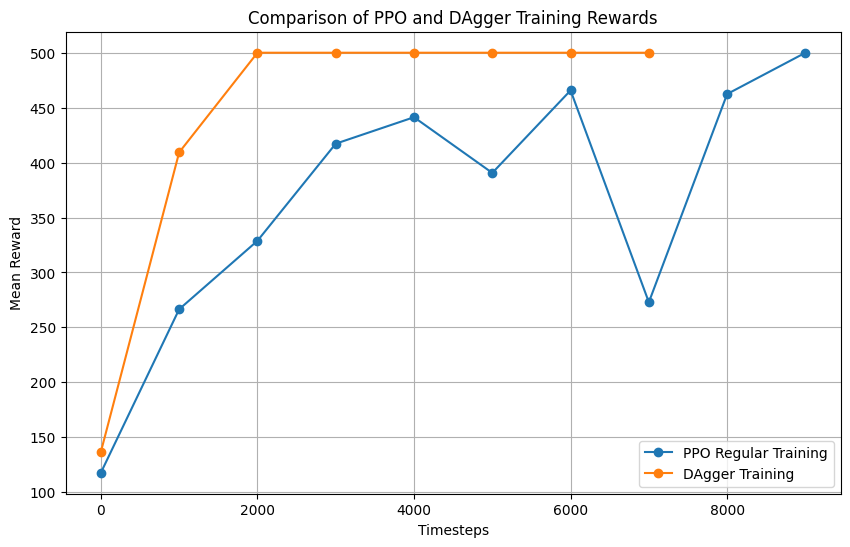

In [5]:
# Plot the rewards for Regular PPO Training and DAgger Training
plt.figure(figsize=(10, 6))
plt.plot(range(0, 10000, 1000), regular_rewards, label="PPO Regular Training", marker="o")
plt.plot(range(0, 8000, 1000), dagger_rewards, label="DAgger Training", marker="o")
plt.xlabel("Timesteps")
plt.ylabel("Mean Reward")
plt.title("Comparison of PPO and DAgger Training Rewards")
plt.legend()
plt.grid(True)
plt.show()


### 3. A2C Agent Training (20 Points)
After DAgger training, a third agent is trained using the **Advantage Actor-Critic (A2C)** algorithm.

In [6]:
env_a2c = gym.make("CartPole-v1")

# Initialize the A2C model with a Multi-layer Perceptron (MlpPolicy)
# and set verbose to 1 for training progress output.
a2c_model = A2C("MlpPolicy", env_a2c)
a2c_rewards = [] # List to store rewards during A2C training

# Define total training timesteps and evaluation frequency for A2C
total_a2c_timesteps = 10000
eval_freq_a2c = 1000

# Training loop for A2C
# The loop iterates, training the model for `eval_freq_a2c` timesteps in each step,
# and then evaluating its performance.
for timestep in range(0, total_a2c_timesteps, eval_freq_a2c):
    # Train the A2C model for a specified number of timesteps
    a2c_model.learn(total_timesteps=eval_freq_a2c)

    # Evaluate the trained A2C model's performance
    # evaluate_policy returns the mean reward and standard deviation.
    # We are interested in the mean reward here.
    reward, _ = evaluate_policy(a2c_model, env_a2c, n_eval_episodes=10) # Evaluate over 10 episodes

    # Record the mean reward for plotting later if needed
    a2c_rewards.append(reward)

    # Print the current training progress and mean reward
    print(f"A2C Training - Step {timestep + eval_freq_a2c}: Mean Reward = {reward}")

# Save the trained A2C model to a zip file.
a2c_model.save("CartPole_v1_A2C_model.zip")

# Close the environment to free up resources
env_a2c.close()

# Optional: Print all collected A2C rewards
# print("All A2C training rewards:", a2c_rewards)


A2C Training - Step 1000: Mean Reward = 58.5
A2C Training - Step 2000: Mean Reward = 64.5
A2C Training - Step 3000: Mean Reward = 137.9
A2C Training - Step 4000: Mean Reward = 88.4
A2C Training - Step 5000: Mean Reward = 85.3
A2C Training - Step 6000: Mean Reward = 198.4
A2C Training - Step 7000: Mean Reward = 165.7
A2C Training - Step 8000: Mean Reward = 267.2
A2C Training - Step 9000: Mean Reward = 408.8
A2C Training - Step 10000: Mean Reward = 310.4


In [7]:
# Create the CartPole-v1 environment for DAgger training
# It's good practice to create a fresh environment for each training phase
# or ensure the existing one is reset properly.
env = gym.make("CartPole-v1")
vec_env = make_vec_env("CartPole-v1", n_envs=1, rng=np.random.default_rng(0)) # DAgger expects a VecEnv

# Load the A2C model manually using Stable-Baselines3's load method
# The path should match where you saved the A2C model.
# Assuming "CartPole_v1_A2C_model.zip" is the name of your saved A2C model.
expert = A2C.load("CartPole_v1_A2C_model.zip", env=env)

# Initialize the Behavior Cloning (BC) trainer
# This acts as the initial policy for DAgger.
# We pass the expert's observation and action space, and the vector environment.
bc_trainer = bc.BC(
    observation_space=vec_env.observation_space,
    action_space=vec_env.action_space,
    rng=np.random.default_rng(0), # For reproducibility
)

# Record rewards during DAgger training
dagger_rewards = []

# Train using DAgger
with tempfile.TemporaryDirectory(prefix="dagger_example_") as tmpdir:
    # Initialize the SimpleDAggerTrainer
    # It requires the vector environment (venv), the expert policy, the BC trainer,
    # and a scratch directory for temporary files.
    dagger_trainer = SimpleDAggerTrainer(
        venv=vec_env,
        expert_policy=expert,
        bc_trainer=bc_trainer,
        scratch_dir=tmpdir, # Added the required 'scratch_dir' argument
        rng=np.random.default_rng(0), # For reproducibility
        # log_dir=tmpdir, # Uncomment to save DAgger logs to a temporary directory
    )

    # Training loop for DAgger
    total_dagger_timesteps = 8000
    eval_freq = 1000
    for timestep in range(0, total_dagger_timesteps, eval_freq):
        # Train the DAgger agent for `eval_freq` timesteps
        dagger_trainer.train(eval_freq)

        # Evaluate the model and record the reward
        # We evaluate the policy learned by the DAgger trainer.
        # The policy is accessible via dagger_trainer.policy.
        reward, _ = evaluate_policy(dagger_trainer.policy, env, n_eval_episodes=10)
        dagger_rewards.append(reward) # Record the reward
        print(f"DAgger Training - Step {timestep + eval_freq}: Mean Reward = {reward}")

# Save the DAgger trained model.
# The policy from the dagger_trainer can be saved using its .save() method.
dagger_trainer.policy.save("CartPole_v1_DAgger_model_from_A2C_expert.zip")

# Close the environment after DAgger training
env.close()
vec_env.close() # Also close the VecEnv

# Optional: Print all collected DAgger rewards
# print("All DAgger training rewards:", dagger_rewards)


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -0.000693 |
|    entropy        | 0.693     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 72.5      |
|    loss           | 0.693     |
|    neglogp        | 0.694     |
|    prob_true_act  | 0.5       |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 32        |
|    return_mean    | 23.6      |
|    return_min     | 11        |
|    return_std     | 7.61      |
---------------------------------


26batch [00:00, 143.95batch/s]
48batch [00:00, 176.14batch/s]
69batch [00:00, 186.69batch/s]
90batch [00:00, 193.28batch/s]
108batch [00:00, 180.11batch/s]


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -0.000607 |
|    entropy        | 0.607     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 78.5      |
|    loss           | 0.401     |
|    neglogp        | 0.402     |
|    prob_true_act  | 0.676     |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 199       |
|    return_mean    | 160       |
|    return_min     | 107       |
|    return_std     | 36.5      |
---------------------------------


47batch [00:01, 70.68batch/s]
103batch [00:01, 113.03batch/s]
156batch [00:01, 153.27batch/s]
199batch [00:02, 182.49batch/s]
216batch [00:02, 103.39batch/s]


DAgger Training - Step 1000: Mean Reward = 294.6


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -0.000167 |
|    entropy        | 0.167     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 96.9      |
|    loss           | 0.0679    |
|    neglogp        | 0.068     |
|    prob_true_act  | 0.939     |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 409       |
|    return_mean    | 341       |
|    return_min     | 262       |
|    return_std     | 53.2      |
---------------------------------


72batch [00:01, 84.16batch/s]
165batch [00:01, 176.67batch/s]
233batch [00:02, 194.31batch/s]
325batch [00:02, 216.49batch/s]
332batch [00:02, 124.81batch/s]


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -6.48e-05 |
|    entropy        | 0.0648    |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 110       |
|    loss           | 0.0237    |
|    neglogp        | 0.0238    |
|    prob_true_act  | 0.978     |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 357       |
|    return_mean    | 306       |
|    return_min     | 270       |
|    return_std     | 32.7      |
---------------------------------


92batch [00:01, 114.80batch/s]
203batch [00:01, 193.61batch/s]
316batch [00:02, 216.66batch/s]
429batch [00:03, 218.91batch/s]
432batch [00:03, 143.04batch/s]


DAgger Training - Step 2000: Mean Reward = 291.4


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -6.27e-05 |
|    entropy        | 0.0627    |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 121       |
|    loss           | 0.0288    |
|    neglogp        | 0.0289    |
|    prob_true_act  | 0.975     |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 379       |
|    return_mean    | 264       |
|    return_min     | 189       |
|    return_std     | 66.8      |
---------------------------------


141batch [00:01, 171.27batch/s]
281batch [00:02, 217.27batch/s]
401batch [00:02, 227.53batch/s]
492batch [00:03, 218.32batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -4.58e-05 |
|    entropy        | 0.0458    |
|    epoch          | 3         |
|    l2_loss        | 0         |
|    l2_norm        | 130       |
|    loss           | 0.0208    |
|    neglogp        | 0.0209    |
|    prob_true_act  | 0.982     |
|    samples_so_far | 16032     |
| rollout/          |           |
|    return_max     | 320       |
|    return_mean    | 300       |
|    return_min     | 285       |
|    return_std     | 15.1      |
---------------------------------


559batch [00:04, 89.25batch/s]
564batch [00:04, 126.02batch/s]


DAgger Training - Step 3000: Mean Reward = 320.4


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -3.73e-05 |
|    entropy        | 0.0373    |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 132       |
|    loss           | 0.0209    |
|    neglogp        | 0.0209    |
|    prob_true_act  | 0.983     |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 434       |
|    return_mean    | 378       |
|    return_min     | 297       |
|    return_std     | 53.5      |
---------------------------------


163batch [00:05, 75.50batch/s]
320batch [00:06, 196.19batch/s]
493batch [00:06, 208.61batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -1.88e-05 |
|    entropy        | 0.0188    |
|    epoch          | 2         |
|    l2_loss        | 0         |
|    l2_norm        | 139       |
|    loss           | 0.00548   |
|    neglogp        | 0.0055    |
|    prob_true_act  | 0.995     |
|    samples_so_far | 16032     |
| rollout/          |           |
|    return_max     | 404       |
|    return_mean    | 311       |
|    return_min     | 253       |
|    return_std     | 51.9      |
---------------------------------



672batch [00:08, 169.72batch/s]
676batch [00:08, 75.88batch/s]


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -7.52e-05 |
|    entropy        | 0.0752    |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 141       |
|    loss           | 0.064     |
|    neglogp        | 0.0641    |
|    prob_true_act  | 0.954     |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 423       |
|    return_mean    | 358       |
|    return_min     | 265       |
|    return_std     | 55.7      |
---------------------------------


180batch [00:02, 182.86batch/s]
387batch [00:02, 217.13batch/s]
500batch [00:03, 220.20batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -2.94e-07 |
|    entropy        | 0.000294  |
|    epoch          | 2         |
|    l2_loss        | 0         |
|    l2_norm        | 146       |
|    loss           | 3.21e-05  |
|    neglogp        | 3.24e-05  |
|    prob_true_act  | 1         |
|    samples_so_far | 16032     |
| rollout/          |           |
|    return_max     | 455       |
|    return_mean    | 357       |
|    return_min     | 280       |
|    return_std     | 65.9      |
---------------------------------


590batch [00:05, 98.21batch/s]
782batch [00:06, 157.33batch/s]
796batch [00:06, 126.80batch/s]


DAgger Training - Step 4000: Mean Reward = 316.6


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -3.71e-05 |
|    entropy        | 0.0371    |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 149       |
|    loss           | 0.0304    |
|    neglogp        | 0.0305    |
|    prob_true_act  | 0.978     |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 464       |
|    return_mean    | 347       |
|    return_min     | 259       |
|    return_std     | 95.4      |
---------------------------------


210batch [00:02, 203.23batch/s]
447batch [00:03, 222.43batch/s]
492batch [00:03, 214.63batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -3.34e-06 |
|    entropy        | 0.00334   |
|    epoch          | 2         |
|    l2_loss        | 0         |
|    l2_norm        | 155       |
|    loss           | 0.000565  |
|    neglogp        | 0.000568  |
|    prob_true_act  | 0.999     |
|    samples_so_far | 16032     |
| rollout/          |           |
|    return_max     | 442       |
|    return_mean    | 331       |
|    return_min     | 231       |
|    return_std     | 79.1      |
---------------------------------


678batch [00:05, 179.11batch/s]
911batch [00:06, 221.88batch/s]
912batch [00:06, 143.62batch/s]


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -9.88e-06 |
|    entropy        | 0.00988   |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 158       |
|    loss           | 0.00207   |
|    neglogp        | 0.00208   |
|    prob_true_act  | 0.998     |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 462       |
|    return_mean    | 324       |
|    return_min     | 275       |
|    return_std     | 69.8      |
---------------------------------


240batch [00:02, 153.49batch/s]
484batch [00:03, 210.60batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -2.08e-05 |
|    entropy        | 0.0208    |
|    epoch          | 1         |
|    l2_loss        | 0         |
|    l2_norm        | 161       |
|    loss           | 0.012     |
|    neglogp        | 0.0121    |
|    prob_true_act  | 0.99      |
|    samples_so_far | 16032     |
| rollout/          |           |
|    return_max     | 300       |
|    return_mean    | 278       |
|    return_min     | 222       |
|    return_std     | 28.4      |
---------------------------------


506batch [00:05, 56.46batch/s] 
748batch [00:06, 202.75batch/s]
999batch [00:07, 218.84batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 1000      |
|    ent_loss       | -3.74e-06 |
|    entropy        | 0.00374   |
|    epoch          | 3         |
|    l2_loss        | 0         |
|    l2_norm        | 165       |
|    loss           | 0.000635  |
|    neglogp        | 0.000639  |
|    prob_true_act  | 0.999     |
|    samples_so_far | 32032     |
| rollout/          |           |
|    return_max     | 395       |
|    return_mean    | 321       |
|    return_min     | 282       |
|    return_std     | 39.1      |
---------------------------------



1020batch [00:08, 119.82batch/s]


DAgger Training - Step 5000: Mean Reward = 291.4


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -4.26e-06 |
|    entropy        | 0.00426   |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 165       |
|    loss           | 0.000845  |
|    neglogp        | 0.00085   |
|    prob_true_act  | 0.999     |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 364       |
|    return_mean    | 307       |
|    return_min     | 275       |
|    return_std     | 30.2      |
---------------------------------


279batch [00:02, 159.59batch/s]
488batch [00:03, 140.83batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -6.29e-09 |
|    entropy        | 6.29e-06  |
|    epoch          | 1         |
|    l2_loss        | 0         |
|    l2_norm        | 169       |
|    loss           | 4.71e-07  |
|    neglogp        | 4.77e-07  |
|    prob_true_act  | 1         |
|    samples_so_far | 16032     |
| rollout/          |           |
|    return_max     | 333       |
|    return_mean    | 295       |
|    return_min     | 256       |
|    return_std     | 24.9      |
---------------------------------


549batch [00:05, 71.22batch/s]
843batch [00:06, 221.57batch/s]
982batch [00:07, 223.57batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 1000      |
|    ent_loss       | -1.18e-05 |
|    entropy        | 0.0118    |
|    epoch          | 3         |
|    l2_loss        | 0         |
|    l2_norm        | 171       |
|    loss           | 0.0661    |
|    neglogp        | 0.0662    |
|    prob_true_act  | 0.972     |
|    samples_so_far | 32032     |
| rollout/          |           |
|    return_max     | 368       |
|    return_mean    | 315       |
|    return_min     | 297       |
|    return_std     | 27        |
---------------------------------


1136batch [00:09, 153.52batch/s]
1136batch [00:09, 124.69batch/s]


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -1.11e-05 |
|    entropy        | 0.0111    |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 171       |
|    loss           | 0.00368   |
|    neglogp        | 0.00369   |
|    prob_true_act  | 0.997     |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 479       |
|    return_mean    | 321       |
|    return_min     | 268       |
|    return_std     | 79.7      |
---------------------------------


304batch [00:02, 223.84batch/s]
493batch [00:03, 224.46batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -1.48e-06 |
|    entropy        | 0.00148   |
|    epoch          | 1         |
|    l2_loss        | 0         |
|    l2_norm        | 174       |
|    loss           | 0.000233  |
|    neglogp        | 0.000235  |
|    prob_true_act  | 1         |
|    samples_so_far | 16032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 335       |
|    return_min     | 282       |
|    return_std     | 83.2      |
---------------------------------


615batch [00:05, 114.54batch/s]
927batch [00:07, 215.98batch/s]
994batch [00:07, 219.58batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 1000      |
|    ent_loss       | -1.84e-05 |
|    entropy        | 0.0184    |
|    epoch          | 3         |
|    l2_loss        | 0         |
|    l2_norm        | 175       |
|    loss           | 0.00895   |
|    neglogp        | 0.00896   |
|    prob_true_act  | 0.992     |
|    samples_so_far | 32032     |
| rollout/          |           |
|    return_max     | 436       |
|    return_mean    | 315       |
|    return_min     | 225       |
|    return_std     | 67.9      |
---------------------------------


1247batch [00:09, 202.01batch/s]
1252batch [00:09, 128.98batch/s]


DAgger Training - Step 6000: Mean Reward = 305.0


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -1.02e-05 |
|    entropy        | 0.0102    |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 177       |
|    loss           | 0.0033    |
|    neglogp        | 0.00331   |
|    prob_true_act  | 0.997     |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 348       |
|    return_min     | 269       |
|    return_std     | 81.5      |
---------------------------------


320batch [00:02, 219.76batch/s]
499batch [00:03, 215.55batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -1.59e-05 |
|    entropy        | 0.0159    |
|    epoch          | 1         |
|    l2_loss        | 0         |
|    l2_norm        | 179       |
|    loss           | 0.0057    |
|    neglogp        | 0.00571   |
|    prob_true_act  | 0.995     |
|    samples_so_far | 16032     |
| rollout/          |           |
|    return_max     | 349       |
|    return_mean    | 310       |
|    return_min     | 268       |
|    return_std     | 32.4      |
---------------------------------


677batch [00:06, 120.63batch/s]
1000batch [00:07, 214.51batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 1000      |
|    ent_loss       | -8.61e-10 |
|    entropy        | 8.61e-07  |
|    epoch          | 2         |
|    l2_loss        | 0         |
|    l2_norm        | 181       |
|    loss           | 5.87e-08  |
|    neglogp        | 5.96e-08  |
|    prob_true_act  | 1         |
|    samples_so_far | 32032     |
| rollout/          |           |
|    return_max     | 322       |
|    return_mean    | 301       |
|    return_min     | 276       |
|    return_std     | 18.1      |
---------------------------------


1022batch [00:08, 53.14batch/s] 
1346batch [00:10, 206.53batch/s]
1364batch [00:10, 130.72batch/s]


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -1.35e-05 |
|    entropy        | 0.0135    |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 182       |
|    loss           | 0.00431   |
|    neglogp        | 0.00432   |
|    prob_true_act  | 0.996     |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 356       |
|    return_mean    | 308       |
|    return_min     | 295       |
|    return_std     | 24        |
---------------------------------


351batch [00:02, 206.07batch/s]
482batch [00:03, 211.95batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -5.38e-08 |
|    entropy        | 5.38e-05  |
|    epoch          | 1         |
|    l2_loss        | 0         |
|    l2_norm        | 183       |
|    loss           | 5.19e-06  |
|    neglogp        | 5.25e-06  |
|    prob_true_act  | 1         |
|    samples_so_far | 16032     |
| rollout/          |           |
|    return_max     | 455       |
|    return_mean    | 337       |
|    return_min     | 259       |
|    return_std     | 65.7      |
---------------------------------


734batch [00:06, 136.08batch/s]
989batch [00:07, 207.94batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 1000      |
|    ent_loss       | -2.54e-05 |
|    entropy        | 0.0254    |
|    epoch          | 2         |
|    l2_loss        | 0         |
|    l2_norm        | 185       |
|    loss           | 0.0267    |
|    neglogp        | 0.0268    |
|    prob_true_act  | 0.982     |
|    samples_so_far | 32032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 334       |
|    return_min     | 262       |
|    return_std     | 86.2      |
---------------------------------


1097batch [00:09, 117.18batch/s]
1484batch [00:11, 212.15batch/s]
1484batch [00:11, 132.23batch/s]


DAgger Training - Step 7000: Mean Reward = 343.6


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -4.62e-08 |
|    entropy        | 4.62e-05  |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 187       |
|    loss           | 4.23e-06  |
|    neglogp        | 4.28e-06  |
|    prob_true_act  | 1         |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 322       |
|    return_mean    | 294       |
|    return_min     | 275       |
|    return_std     | 18.9      |
---------------------------------


389batch [00:03, 151.57batch/s]
485batch [00:03, 149.78batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -8.58e-07 |
|    entropy        | 0.000858  |
|    epoch          | 1         |
|    l2_loss        | 0         |
|    l2_norm        | 189       |
|    loss           | 0.000117  |
|    neglogp        | 0.000118  |
|    prob_true_act  | 1         |
|    samples_so_far | 16032     |
| rollout/          |           |
|    return_max     | 322       |
|    return_mean    | 283       |
|    return_min     | 215       |
|    return_std     | 36        |
---------------------------------


777batch [00:06, 199.42batch/s]
990batch [00:07, 206.23batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | -4e-07   |
|    entropy        | 0.0004   |
|    epoch          | 2        |
|    l2_loss        | 0        |
|    l2_norm        | 189      |
|    loss           | 4.87e-05 |
|    neglogp        | 4.91e-05 |
|    prob_true_act  | 1        |
|    samples_so_far | 32032    |
| rollout/          |          |
|    return_max     | 402      |
|    return_mean    | 321      |
|    return_min     | 294      |
|    return_std     | 40.8     |
--------------------------------


1182batch [00:09, 174.90batch/s]
1483batch [00:10, 214.12batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 1500      |
|    ent_loss       | -3.32e-06 |
|    entropy        | 0.00332   |
|    epoch          | 3         |
|    l2_loss        | 0         |
|    l2_norm        | 190       |
|    loss           | 0.000666  |
|    neglogp        | 0.00067   |
|    prob_true_act  | 0.999     |
|    samples_so_far | 48032     |
| rollout/          |           |
|    return_max     | 317       |
|    return_mean    | 291       |
|    return_min     | 266       |
|    return_std     | 19        |
---------------------------------


1589batch [00:12, 124.06batch/s]
1592batch [00:12, 127.57batch/s]


Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1 [00:00<?, ? examples/s]

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -3.96e-06 |
|    entropy        | 0.00396   |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 190       |
|    loss           | 0.000872  |
|    neglogp        | 0.000876  |
|    prob_true_act  | 0.999     |
|    samples_so_far | 32        |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 380       |
|    return_min     | 289       |
|    return_std     | 98.3      |
---------------------------------


426batch [00:03, 208.16batch/s]
491batch [00:04, 208.95batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -1.01e-05 |
|    entropy        | 0.0101    |
|    epoch          | 1         |
|    l2_loss        | 0         |
|    l2_norm        | 191       |
|    loss           | 0.00302   |
|    neglogp        | 0.00303   |
|    prob_true_act  | 0.997     |
|    samples_so_far | 16032     |
| rollout/          |           |
|    return_max     | 500       |
|    return_mean    | 346       |
|    return_min     | 260       |
|    return_std     | 87        |
---------------------------------


845batch [00:07, 211.91batch/s]
980batch [00:07, 210.64batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | -2e-05   |
|    entropy        | 0.02     |
|    epoch          | 2        |
|    l2_loss        | 0        |
|    l2_norm        | 191      |
|    loss           | 0.034    |
|    neglogp        | 0.034    |
|    prob_true_act  | 0.979    |
|    samples_so_far | 32032    |
| rollout/          |          |
|    return_max     | 500      |
|    return_mean    | 359      |
|    return_min     | 277      |
|    return_std     | 80.5     |
--------------------------------


1272batch [00:10, 215.03batch/s]
1478batch [00:11, 220.67batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 1500      |
|    ent_loss       | -7.53e-07 |
|    entropy        | 0.000753  |
|    epoch          | 3         |
|    l2_loss        | 0         |
|    l2_norm        | 191       |
|    loss           | 9.82e-05  |
|    neglogp        | 9.89e-05  |
|    prob_true_act  | 1         |
|    samples_so_far | 48032     |
| rollout/          |           |
|    return_max     | 296       |
|    return_mean    | 284       |
|    return_min     | 269       |
|    return_std     | 10.5      |
---------------------------------


1708batch [00:13, 146.11batch/s]
1716batch [00:13, 126.77batch/s]


DAgger Training - Step 8000: Mean Reward = 326.5


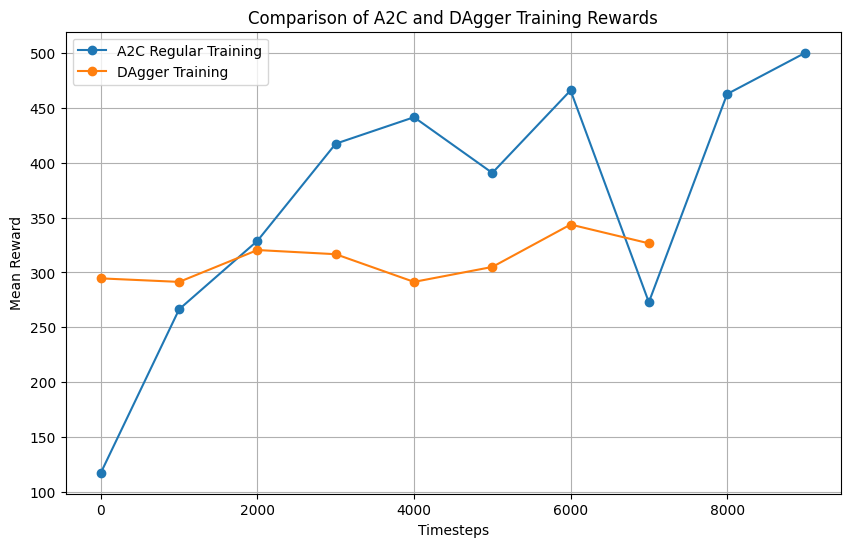

In [8]:
# Plot the rewards for Regular A2C Training and DAgger Training
plt.figure(figsize=(10, 6))
plt.plot(range(0, 10000, 1000), regular_rewards, label="A2C Regular Training", marker="o")
plt.plot(range(0, 8000, 1000), dagger_rewards, label="DAgger Training", marker="o")

plt.xlabel("Timesteps")
plt.ylabel("Mean Reward")
plt.title("Comparison of A2C and DAgger Training Rewards")
plt.legend()

plt.grid(True)
plt.show()

# Training a GAIL Model Using an Expert Policy

In this section, we walk through the process of setting up and training a **Generative Adversarial Imitation Learning (GAIL)** model using a pre-trained expert in environments such as `CartPole-v1`, `Pendulum-v0`, and `BipedalWalker-v3`.

The full pipeline includes:
- Setting up directories and configurations,
- Loading and validating the environment,
- Initializing expert and GAIL models,
- Training GAIL using the expert’s behavior,
- Saving the final results and model weights.

## Summary

This pipeline implements a complete imitation learning workflow using GAIL. The process involves:
- Setting up a Gym-compatible environment,
- Loading a pre-trained expert model,
- Training a GAIL agent to mimic the expert,
- Storing the training results and model artifacts.

By following this structure, we can compare GAIL's performance to reinforcement learning approaches like PPO or A2C, and evaluate the efficiency of learning from demonstrations.

---


In [14]:
import numpy as np
import torch
device = setup_device()

from torch.nn import Module, Sequential, Linear, Tanh, Parameter, Embedding
from torch.distributions import Categorical, MultivariateNormal
class PolicyNetwork(Module):
    def __init__(self, state_dim, action_dim, discrete) -> None:
        super().__init__()

        self.net = Sequential(
            Linear(state_dim, 50),
            Tanh(),
            Linear(50, 50),
            Tanh(),
            Linear(50, 50),
            Tanh(),
            Linear(50, action_dim),
        )

        self.state_dim = state_dim
        self.action_dim = action_dim
        self.discrete = discrete

        if not self.discrete:
            self.log_std = Parameter(torch.zeros(action_dim))

    def forward(self, states):
        if self.discrete:
            probs = torch.softmax(self.net(states), dim=-1)
            distb = Categorical(probs)
        else:

            mean = self.net(states)
            std = torch.exp(self.log_std)
            cov_mtx = torch.eye(self.action_dim, device=device) * (std ** 2)

            distb = MultivariateNormal(mean, cov_mtx)

        return distb
class Expert(Module):
    def __init__(
        self,
        state_dim,
        action_dim,
        discrete,
        train_config=None
    ) -> None:
        super().__init__()

        self.state_dim = state_dim
        self.action_dim = action_dim
        self.discrete = discrete
        self.train_config = train_config

        self.pi = PolicyNetwork(self.state_dim, self.action_dim, self.discrete)

    def get_networks(self):
        return [self.pi]

    def act(self, state):
        self.pi.eval()

        state = torch.tensor(state, dtype=torch.float32, device=device)
        distb = self.pi(state)

        action = distb.sample().detach().cpu().numpy()

        return action


Using GPU: Tesla T4


In [15]:

def get_flat_grads(f, net):
    flat_grads = torch.cat([
        grad.view(-1)
        for grad in torch.autograd.grad(f, net.parameters(), create_graph=True)
    ])

    return flat_grads


def get_flat_params(net):
    return torch.cat([param.view(-1) for param in net.parameters()])


def set_params(net, new_flat_params):
    start_idx = 0
    for param in net.parameters():
        end_idx = start_idx + np.prod(list(param.shape))
        param.data = torch.reshape(
            new_flat_params[start_idx:end_idx], param.shape
        )

        start_idx = end_idx


def conjugate_gradient(Av_func, b, max_iter=10, residual_tol=1e-10):
    x = torch.zeros_like(b)
    r = b - Av_func(x)
    p = r
    rsold = r.norm() ** 2

    for _ in range(max_iter):
        Ap = Av_func(p)
        alpha = rsold / torch.dot(p, Ap)
        x = x + alpha * p
        r = r - alpha * Ap
        rsnew = r.norm() ** 2
        if torch.sqrt(rsnew) < residual_tol:
            break
        p = r + (rsnew / rsold) * p
        rsold = rsnew

    return x


def rescale_and_linesearch(
    g, s, Hs, max_kl, L, kld, old_params, pi, max_iter=10,
    success_ratio=0.1
):
    set_params(pi, old_params)
    L_old = L().detach()

    beta = torch.sqrt((2 * max_kl) / torch.dot(s, Hs))

    for _ in range(max_iter):
        new_params = old_params + beta * s

        set_params(pi, new_params)
        kld_new = kld().detach()

        L_new = L().detach()

        actual_improv = L_new - L_old
        approx_improv = torch.dot(g, beta * s)
        ratio = actual_improv / approx_improv

        if ratio > success_ratio \
            and actual_improv > 0 \
                and kld_new < max_kl:
            return new_params

        beta *= 0.5

    print("The line search was failed!")
    return old_params



np.bool8 = np.bool_



class ValueNetwork(Module):
    def __init__(self, state_dim) -> None:
        super().__init__()

        self.net = Sequential(
            Linear(state_dim, 50),
            Tanh(),
            Linear(50, 50),
            Tanh(),
            Linear(50, 50),
            Tanh(),
            Linear(50, 1),
        )

    def forward(self, states):
        return self.net(states)


class Discriminator(Module):
    def __init__(self, state_dim, action_dim, discrete) -> None:
        super().__init__()

        self.state_dim = state_dim
        self.action_dim = action_dim
        self.discrete = discrete

        if self.discrete:
            self.act_emb = Embedding(
                action_dim, state_dim
            )
            self.net_in_dim = 2 * state_dim
        else:
            self.net_in_dim = state_dim + action_dim

        self.net = Sequential(
            Linear(self.net_in_dim, 50),
            Tanh(),
            Linear(50, 50),
            Tanh(),
            Linear(50, 50),
            Tanh(),
            Linear(50, 1),
        )

    def forward(self, states, actions):
        return torch.sigmoid(self.get_logits(states, actions))

    def get_logits(self, states, actions):
        if self.discrete:
            actions = self.act_emb(actions.long())

        sa = torch.cat([states, actions], dim=-1)

        return self.net(sa)



class GAIL(Module):
    def __init__(
        self,
        state_dim,
        action_dim,
        discrete,
        train_config=None
    ) -> None:
        super().__init__()

        self.state_dim = state_dim
        self.action_dim = action_dim
        self.discrete = discrete
        self.train_config = train_config

        self.pi = PolicyNetwork(self.state_dim, self.action_dim, self.discrete)
        self.v = ValueNetwork(self.state_dim)

        self.d = Discriminator(self.state_dim, self.action_dim, self.discrete)

    def get_networks(self):
        return [self.pi, self.v]

    def act(self, state):
        self.pi.eval()

        state = torch.tensor(state, dtype=torch.float32, device=device)
        distb = self.pi(state)

        action = distb.sample().detach().cpu().numpy()

        return action

    def train(self, env, expert, render=False):
        num_iters = self.train_config["num_iters"]
        num_steps_per_iter = self.train_config["num_steps_per_iter"]
        horizon = self.train_config["horizon"]
        lambda_ = self.train_config["lambda"]
        gae_gamma = self.train_config["gae_gamma"]
        gae_lambda = self.train_config["gae_lambda"]
        eps = self.train_config["epsilon"]
        max_kl = self.train_config["max_kl"]
        cg_damping = self.train_config["cg_damping"]
        normalize_advantage = self.train_config["normalize_advantage"]

        opt_d = torch.optim.Adam(self.d.parameters())

        exp_rwd_iter = []

        exp_obs = []
        exp_acts = []

        steps = 0
        while steps < num_steps_per_iter:
            ep_obs = []
            ep_rwds = []

            t = 0
            done = False

            ob, _ = env.reset()

            while not done and steps < num_steps_per_iter:
                act = expert.act(ob)

                ep_obs.append(ob)
                exp_obs.append(ob)
                exp_acts.append(act)

                if render:
                    env.render()
                ob, rwd, terminated, truncated, info = env.step(act)
                done = terminated or truncated
                ep_rwds.append(rwd)

                t += 1
                steps += 1
                if steps==500:
                    a = sum(ep_rwds)
                if horizon is not None:
                    if t >= horizon:
                        done = True
                        break

            if done:
                exp_rwd_iter.append(np.sum(ep_rwds))

            ep_obs = torch.tensor(np.array(ep_obs), dtype=torch.float32, device=device)
            ep_rwds = torch.tensor(ep_rwds, dtype=torch.float32, device=device)

        exp_rwd_mean = np.mean(exp_rwd_iter)
        print(
            "Expert Reward Mean: {}".format(exp_rwd_mean)
        )

        exp_obs = torch.tensor(np.array(exp_obs), dtype=torch.float32, device=device)
        exp_acts = torch.tensor(np.array(exp_acts), dtype=torch.float32, device=device)

        rwd_iter_means = []
        for i in range(num_iters):
            rwd_iter = []

            obs = []
            acts = []
            rets = []
            advs = []
            gms = []

            steps = 0
            while steps < num_steps_per_iter:
                ep_obs = []
                ep_acts = []
                ep_rwds = []
                ep_costs = []
                ep_disc_costs = []
                ep_gms = []
                ep_lmbs = []

                t = 0
                done = False

                ob, _ = env.reset()

                while not done and steps < num_steps_per_iter:
                    act = self.act(ob)

                    ep_obs.append(ob)
                    obs.append(ob)

                    ep_acts.append(act)
                    acts.append(act)

                    if render:
                        env.render()
                    ob, rwd, terminated, truncated, info = env.step(act)
                    done = terminated or truncated
                    ep_rwds.append(rwd)
                    ep_gms.append(gae_gamma ** t)
                    ep_lmbs.append(gae_lambda ** t)

                    t += 1
                    steps += 1

                    if horizon is not None:
                        if t >= horizon:
                            done = True
                            break

                if done:
                    rwd_iter.append(np.sum(ep_rwds))

                ep_obs = torch.tensor(np.array(ep_obs), dtype=torch.float32, device=device)
                ep_acts = torch.tensor(np.array(ep_acts), dtype=torch.float32, device=device)
                ep_rwds = torch.tensor(ep_rwds, dtype=torch.float32, device=device)
                # ep_disc_rwds = torch.tensor(ep_disc_rwds, dtype=torch.float32, device=device)
                ep_gms = torch.tensor(ep_gms, dtype=torch.float32, device=device)
                ep_lmbs = torch.tensor(ep_lmbs, dtype=torch.float32, device=device)

                ep_costs = (-1) * torch.log(self.d(ep_obs, ep_acts))\
                    .squeeze().detach()
                ep_disc_costs = ep_gms * ep_costs

                ep_disc_rets = torch.tensor([sum(ep_disc_costs[i:]) for i in range(t)], dtype=torch.float32, device=device)
                ep_rets = ep_disc_rets / ep_gms

                rets.append(ep_rets)

                self.v.eval()
                curr_vals = self.v(ep_obs).detach()
                next_vals = torch.cat(
                    (self.v(ep_obs)[1:], torch.tensor([[0.]], dtype=torch.float32, device=device))
                ).detach()
                ep_deltas = ep_costs.unsqueeze(-1)\
                    + gae_gamma * next_vals\
                    - curr_vals

                ep_advs = torch.tensor([
                    ((ep_gms * ep_lmbs)[:t - j].unsqueeze(-1) * ep_deltas[j:])
                    .sum()
                    for j in range(t)
                ], dtype=torch.float32, device=device)
                advs.append(ep_advs)

                gms.append(ep_gms)

            rwd_iter_means.append(np.mean(rwd_iter))
            print(
                "Iterations: {},   Reward Mean: {}"
                .format(i + 1, np.mean(rwd_iter))
            )

            obs = torch.tensor(np.array(obs), dtype=torch.float32, device=device)
            acts = torch.tensor(np.array(acts), dtype=torch.float32, device=device)
            rets = torch.cat(rets)
            advs = torch.cat(advs)
            gms = torch.cat(gms)

            if normalize_advantage:
                advs = (advs - advs.mean()) / advs.std()

            self.d.train()
            exp_scores = self.d.get_logits(exp_obs, exp_acts)
            nov_scores = self.d.get_logits(obs, acts)

            opt_d.zero_grad()
            loss = torch.nn.functional.binary_cross_entropy_with_logits(
                exp_scores, torch.zeros_like(exp_scores)
            ) \
                + torch.nn.functional.binary_cross_entropy_with_logits(
                    nov_scores, torch.ones_like(nov_scores)
                )
            loss.backward()
            opt_d.step()

            self.v.train()
            old_params = get_flat_params(self.v).detach()
            old_v = self.v(obs).detach()

            def constraint():
                return ((old_v - self.v(obs)) ** 2).mean()

            grad_diff = get_flat_grads(constraint(), self.v)

            def Hv(v):
                hessian = get_flat_grads(torch.dot(grad_diff, v), self.v)\
                    .detach()

                return hessian

            g = get_flat_grads(
                ((-1) * (self.v(obs).squeeze() - rets) ** 2).mean(), self.v
            ).detach()
            s = conjugate_gradient(Hv, g).detach()

            Hs = Hv(s).detach()
            alpha = torch.sqrt(2 * eps / torch.dot(s, Hs))

            new_params = old_params + alpha * s

            set_params(self.v, new_params)

            self.pi.train()
            old_params = get_flat_params(self.pi).detach()
            old_distb = self.pi(obs)

            def L():
                distb = self.pi(obs)

                return (advs * torch.exp(
                            distb.log_prob(acts)
                            - old_distb.log_prob(acts).detach()
                        )).mean()

            def kld():
                distb = self.pi(obs)

                if self.discrete:
                    old_p = old_distb.probs.detach()
                    p = distb.probs

                    return (old_p * (torch.log(old_p) - torch.log(p)))\
                        .sum(-1)\
                        .mean()

                else:
                    old_mean = old_distb.mean.detach()
                    old_cov = old_distb.covariance_matrix.sum(-1).detach()
                    mean = distb.mean
                    cov = distb.covariance_matrix.sum(-1)

                    return (0.5) * (
                            (old_cov / cov).sum(-1)
                            + (((old_mean - mean) ** 2) / cov).sum(-1)
                            - self.action_dim
                            + torch.log(cov).sum(-1)
                            - torch.log(old_cov).sum(-1)
                        ).mean()

            grad_kld_old_param = get_flat_grads(kld(), self.pi)

            def Hv(v):
                hessian = get_flat_grads(
                    torch.dot(grad_kld_old_param, v),
                    self.pi
                ).detach()

                return hessian + cg_damping * v

            g = get_flat_grads(L(), self.pi).detach()

            s = conjugate_gradient(Hv, g).detach()
            Hs = Hv(s).detach()

            new_params = rescale_and_linesearch(
                g, s, Hs, max_kl, L, kld, old_params, self.pi
            )

            disc_causal_entropy = ((-1) * gms * self.pi(obs).log_prob(acts))\
                .mean()
            grad_disc_causal_entropy = get_flat_grads(
                disc_causal_entropy, self.pi
            )
            new_params += lambda_ * grad_disc_causal_entropy

            set_params(self.pi, new_params)

        return exp_rwd_mean, rwd_iter_means

### **1. `setup_directories(env_name)`** (5 Points)

```python
This function handles directory setup and expert configuration:
- Creates a base checkpoint directory (`ckpts/`).
- Validates if the provided environment name is supported.
- Loads the expert model configuration from a JSON file.
- Creates a subdirectory for storing environment-specific checkpoints.

**Purpose:** Prepare the file system and load settings for the expert model.

In [3]:
def setup_directories(env_name):
    # Base directory for saving checkpoints
    ckpt_path = "ckpts"

    # Create the checkpoint directory if it doesn't exist
    if not os.path.isdir(ckpt_path):
        os.mkdir(ckpt_path)

    # Check if the provided environment name is valid
    if env_name not in ["CartPole-v1", "Pendulum-v0", "BipedalWalker-v3"]:
        print("The environment name is wrong!")
        return None

    # Path to the directory where expert models are stored
    expert_ckpt_path = "experts"
    expert_ckpt_dir = os.path.join(expert_ckpt_path, env_name)

    # Path to the expert model's configuration file
    # TODO: Add error handling in case the file does not exist or is corrupted
    expert_config = os.path.join(expert_ckpt_dir, "model_config.json")

    # Load the expert model's configuration from JSON file
    with open(expert_config, "r") as f:
        expert_config = json.load(f)

    # Create a subdirectory in ckpts for the specific environment
    ckpt_path = os.path.join('ckpts', env_name)
    os.makedirs(ckpt_path, exist_ok=True)

    # Return paths and configuration dictionary
    return expert_ckpt_dir, expert_config, ckpt_path


### **2. `load_and_save_configs(expert_ckpt_path, ckpt_path, env_name)`** (10 Points)
- Loads a general configuration file (`config.json`) that contains training hyperparameters specific to the environment.
- Saves these configurations to the current checkpoint folder for logging and reproducibility.

**Purpose:** Fetch and store hyperparameters needed for training the GAIL model.

In [17]:
def load_and_save_configs(expert_ckpt_path, ckpt_path, env_name):
    # Path to the global configuration file
    # TODO: Ensure that the file path is correct and the file actually exists
    config_path = "config.json"

    # Load the global configuration JSON file
    with open(config_path, "r") as f:
        global_config = json.load(f)

    # Extract the configuration specific to the given environment
    # TODO: Add error handling in case env_name is not in global_config
    config = global_config[env_name]

    # Ensure the checkpoint directory exists
    os.makedirs(ckpt_path, exist_ok=True)

    # Path to save the extracted environment-specific configuration
    #       Also, the absolute path might overwrite the original file unintentionally
    save_path = os.path.join(ckpt_path, "config.json")

    # Save the environment-specific configuration to a JSON file
    with open(save_path, "w") as f:
        json.dump(config, f, indent=4)

    # Return the loaded environment-specific configuration
    return config


### **3. `setup_environment(env_name)`** (10 Points)

- Initializes the chosen environment using OpenAI Gym.
- Extracts the dimensions of the state and action spaces.
- Checks whether the action space is discrete (e.g., CartPole) or continuous (e.g., Pendulum).

**Purpose:** Provide key environment information for model initialization.


In [5]:
def setup_environment(env_name):
    # Create the Gym environment using the provided environment name
    env = gym.make(env_name)

    # Reset the environment to get the initial observation
    # Some Gym environments return (obs, info); older versions return just obs
    obs, _ = env.reset()

    # Get the observation space of the environment
    obs_space = env.observation_space

    # Determine the state (observation) dimension
    if isinstance(obs_space, gym.spaces.Box):
        # For continuous spaces, the state dimension is the product of the shape
        state_dim = int(np.prod(obs_space.shape))
    elif isinstance(obs_space, gym.spaces.Discrete):
        # For discrete spaces, the number of states is obs_space.n
        state_dim = obs_space.n
    else:
        # TODO: Handle or raise an error for unsupported observation space types
        raise NotImplementedError("Unsupported observation space type")

    # Get the action space of the environment
    act_space = env.action_space

    # Determine the action space properties
    if isinstance(act_space, gym.spaces.Discrete):
        discrete = True
        action_dim = act_space.n
    elif isinstance(act_space, gym.spaces.Box):
        discrete = False
        action_dim = int(np.prod(act_space.shape))
    else:
        # TODO: Handle or raise an error for unsupported action space types
        raise NotImplementedError("Unsupported action space type")

    # Return the environment object, state dimension, action dimension, and a flag indicating if the action space is discrete
    return env, state_dim, action_dim, discrete


### **4. `setup_device()`** (+5 Points for running on GPU)
- Checks if a GPU (`cuda`) is available.
- Falls back to CPU if GPU is not detected.

**Purpose:** Ensure the training runs on the optimal hardware available.


In [6]:
def setup_device():
    # TODO: Ensure device compatibility and fallback to CPU if no GPU available
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    else:
        device = torch.device("cpu")
        print("CUDA not available, using CPU.")
    return device

### **5. `initialize_expert(...)`** (15 Points)

- Initializes an `Expert` model using its architecture config and environment dimensions.
- Loads pre-trained policy weights (`policy.ckpt`) from the expert checkpoint.

**Purpose:** Prepare a high-performance expert model whose behavior GAIL will learn to imitate.

In [7]:
def initialize_expert(expert_ckpt_path, state_dim, action_dim, discrete, expert_config, device):
    # TODO: Confirm that the Expert class is loaded with the correct parameters
    # TODO: Ensure that the policy checkpoint for the expert is available
    expert = Expert(state_dim, action_dim, discrete, **expert_config).to(device)

    policy_path = os.path.join(expert_ckpt_path, "policy.ckpt")

    state_dict = torch.load(policy_path, map_location=device)
    expert.pi.load_state_dict(state_dict)
    expert.eval()

    return expert

### **6. `initialize_gail_model(...)`** (15 Points)
- Initializes the `GAIL` model using environment specs and configuration parameters.
- The model includes a policy, value function, and discriminator.

**Purpose:** Set up the GAIL agent that learns by interacting with the environment and distinguishing between expert and learner behavior.


In [8]:
def initialize_gail_model(state_dim, action_dim, discrete, config, device):
    # TODO: Verify that the GAIL model is initialized correctly with the config
    model = GAIL(state_dim, action_dim, discrete, config).to(device)
    return model

### **7. `train_gail_model(model, env, expert)`** (20 Points)
- Runs the training loop for the GAIL agent.
- The GAIL model tries to imitate the expert by fooling the discriminator into thinking the learner’s actions come from the expert.

**Purpose:** Train the policy using imitation learning via adversarial training.


In [9]:
def train_gail_model(model, env, expert):
    # TODO: Verify the training loop is functioning as expected
    results = model.train(env, expert)
    return results

### **8. `save_results_and_checkpoints(...)`** (+5 Points)
- Saves training results (e.g., episode returns) as a pickle file.
- Saves the weights of the trained components: policy, value network, and discriminator.

**Purpose:** Store the final model and results for evaluation and future use.


In [10]:
def save_results_and_checkpoints(ckpt_path, results, model):
    # TODO: Confirm that training results are serialized correctly
    # TODO: Confirm that the model weights are saved correctly for each component

    os.makedirs(ckpt_path, exist_ok=True)


    results_path = os.path.join(ckpt_path, "results.pkl")
    with open(results_path, "wb") as f:
        pickle.dump(results, f)

    if hasattr(model, "pi"):
        policy_path = os.path.join(ckpt_path, "policy.ckpt")
        torch.save(model.pi.state_dict(), policy_path)

    if hasattr(model, "v"):
        value_path = os.path.join(ckpt_path, "value.ckpt")
        torch.save(model.v.state_dict(), value_path)

    if hasattr(model, "d"):
        disc_path = os.path.join(ckpt_path, "discriminator.ckpt")
        torch.save(model.d.state_dict(), disc_path)

### 9. **`main()`** (25 Points)
- The main function orchestrates the entire GAIL training process.
- It calls all the above functions in sequence to set up directories, load configurations, initialize models, train the GAIL agent, and save results.


In [11]:
# Part 10: Main Function

def main(env_name):
    # Set up directories and validate environment
    expert_ckpt_path, expert_config, ckpt_path = setup_directories(env_name)
    print(expert_ckpt_path)
    if not expert_ckpt_path:
        return
    # Load and save configuration files
    config = load_and_save_configs(expert_ckpt_path, ckpt_path, env_name)
    # Set up environment and get dimensions
    env, state_dim, action_dim, discrete = setup_environment(env_name)
    # Set up the device (CPU or GPU)
    device = setup_device()
    # Initialize expert model
    expert = initialize_expert(expert_ckpt_path, state_dim, action_dim, discrete, expert_config, device)
    # Initialize GAIL model
    model = initialize_gail_model(state_dim, action_dim, discrete, config, device)
    # Train the GAIL model
    results = train_gail_model(model, env, expert)
    # Close the environment
    env.close()
    # Save results and model checkpoints
    save_results_and_checkpoints(ckpt_path, results, model)

### 10. **`run_gail(env_name)`** (+5 Points if using parse_args)
- This function serves as the entry point for running the GAIL training pipeline.
- It accepts an environment name as input and executes the entire GAIL training process.


In [12]:
!unzip experts.zip

Archive:  experts.zip
   creating: experts/
   creating: experts/BipedalWalker-v3/
  inflating: experts/BipedalWalker-v3/model_config.json  
  inflating: experts/BipedalWalker-v3/policy.ckpt  
   creating: experts/CartPole-v1/
  inflating: experts/CartPole-v1/model_config.json  
  inflating: experts/CartPole-v1/policy.ckpt  
   creating: experts/Pendulum-v0/
  inflating: experts/Pendulum-v0/model_config.json  
  inflating: experts/Pendulum-v0/policy.ckpt  


In [18]:
# TODO: Ensure that the command-line arguments are parsed correctly
parser = argparse.ArgumentParser()
parser.add_argument(
    "--env_name",
    type=str,
    default="CartPole-v1",
)
args, _ = parser.parse_known_args()

main(args.env_name)

# Run the Main Function
# TODO: Verify that the correct environment name is passed to the main function


experts/CartPole-v1
Using GPU: Tesla T4
Expert Reward Mean: 500.0
Iterations: 1,   Reward Mean: 24.567901234567902
Iterations: 2,   Reward Mean: 25.243589743589745
Iterations: 3,   Reward Mean: 34.03448275862069
Iterations: 4,   Reward Mean: 41.765957446808514
Iterations: 5,   Reward Mean: 57.5
Iterations: 6,   Reward Mean: 86.56521739130434
Iterations: 7,   Reward Mean: 142.23076923076923
Iterations: 8,   Reward Mean: 133.26666666666668
Iterations: 9,   Reward Mean: 187.7
Iterations: 10,   Reward Mean: 358.0
Iterations: 11,   Reward Mean: 260.57142857142856
Iterations: 12,   Reward Mean: 258.42857142857144
Iterations: 13,   Reward Mean: 284.85714285714283
Iterations: 14,   Reward Mean: 354.8
Iterations: 15,   Reward Mean: 398.75
Iterations: 16,   Reward Mean: 427.0
Iterations: 17,   Reward Mean: 437.75
Iterations: 18,   Reward Mean: 500.0
Iterations: 19,   Reward Mean: 500.0
Iterations: 20,   Reward Mean: 275.8333333333333
Iterations: 21,   Reward Mean: 482.25
Iterations: 22,   Reward

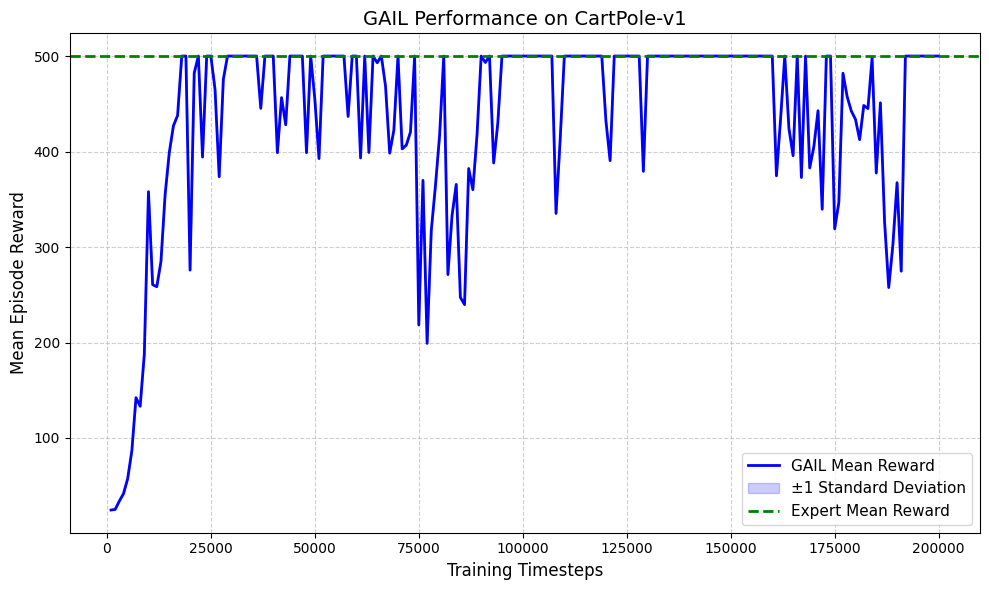

In [19]:


# === Settings ===
env_name = "CartPole-v1"           # Gym environment name
eval_freq = 1000                   # Timesteps between evaluations

# === Load Evaluation Results ===
ckpt_dir = os.path.join("ckpts", env_name)
results_path = os.path.join(ckpt_dir, "results.pkl")

if not os.path.exists(results_path):
    raise FileNotFoundError(f"Results file not found: {results_path}")

with open(results_path, "rb") as f:
    expert_mean, gail_data = pickle.load(f)

# === Parse GAIL Data ===
if isinstance(gail_data, dict):
    # Dictionary format: contains "mean" and "std"
    means = np.array(gail_data["mean"])
    stds  = np.array(gail_data["std"])
else:
    # Raw array format: compute mean and std manually
    arr = np.array(gail_data)
    if arr.ndim == 2:
        means = arr.mean(axis=1)
        stds  = arr.std(axis=1)
    elif arr.ndim == 1:
        means = arr
        stds  = np.zeros_like(arr)
    else:
        raise ValueError("Unexpected shape for gail_data")

# === X-Axis: Actual Timesteps ===
timesteps = np.arange(1, len(means) + 1) * eval_freq

# === Plotting ===
plt.figure(figsize=(10, 6))

# Plot mean reward
plt.plot(timesteps, means, color="blue", linewidth=2, label="GAIL Mean Reward")

# Plot variance as shaded area
plt.fill_between(
    timesteps,
    means - stds,
    means + stds,
    color="blue",
    alpha=0.2,
    label="±1 Standard Deviation"
)

# Plot expert baseline
plt.axhline(
    y=expert_mean,
    color="green",
    linestyle="--",
    linewidth=2,
    label="Expert Mean Reward"
)

# === Plot Formatting ===
plt.title(f"GAIL Performance on {env_name}", fontsize=14)
plt.xlabel("Training Timesteps", fontsize=12)
plt.ylabel("Mean Episode Reward", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


provide a plot like below:

![image.png](attachment:image.png)